In [1]:
%matplotlib inline
import intake

import xarray as xr
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from   matplotlib import gridspec
from scipy import stats as scipy_stats 

import cmocean
import datashader as ds
from datashader.mpl_ext import dsshow

import cartopy.crs as ccrs
import cartopy.feature as cf

import gribscan

cat_yaml = "/work/bd1154/highresmonsoon/experiments/monsoon2.yaml"
cat = intake.open_catalog(cat_yaml)

print("Available Monsoon 2.0 runs:", *list(cat))

Available Monsoon 2.0 runs: luk1000 luk1001 luk1002 luk1003 luk1010 luk1011 luk1020 luk1021 luk1022 luk1023 luk1030 luk1031 luk1103 luk1123 luk2000 luk2000_zarr luk2001 luk2002 grids


In [2]:
data = cat["luk1001"].to_dask()
data

<xarray.Dataset>
Dimensions:        (time: 8785, cell: 20971520, time3D: 27, level: 90,
                    halflevel: 91)
Coordinates:
  * halflevel      (halflevel) float64 1.0 2.0 3.0 4.0 ... 88.0 89.0 90.0 91.0
  * level          (level) float64 1.0 2.0 3.0 4.0 5.0 ... 87.0 88.0 89.0 90.0
  * time           (time) datetime64[ns] 2020-04-01 ... 2020-10-01
  * time3D         (time3D) datetime64[ns] 2020-04-01 2020-04-08 ... 2020-09-30
Dimensions without coordinates: cell
Data variables: (12/55)
    albedo         (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    cli            (time3D, level, cell) float64 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    clivi          (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    cllvi          (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    clt            (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    clw            (time3D, level, cell) float64 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    ...             ...
    unknown        (level, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    va             (time3D, level, cell) float64 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    vas            (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    wa             (time3D, halflevel, cell) float64 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    zg             (level, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    zghalf         (halflevel, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             mpim
    centreDescription:  Max Planck Institute for Meteorology 
    subCentre:          3
    uuidOfHGrid:        0f1e7d66-637e-11e8-913b-51232bb4d8f9
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ma...

In [3]:
# drop all data but 'clt' (small subset for fast prototyping)

varnames = list(ds.keys())
varnames.sort()
# remove the desired variables from the delete list
desired_variables = ['rlds', 'rldscs', 'rlus', 'rlut', 'rlutcs', 'rsds', 'rsdscs', 'rsus', 'rsuscs', 'rsut', 'rsutcs', 'clt' ]
for x in desired_variables:
  varnames.remove(x)
varnames += ['vlon', 'vlat', 'elon', 'elat'] # add vertice and edge locations
ds = ds.drop_vars(varnames)


AttributeError: module 'datashader' has no attribute 'keys'

In [ ]:
import time

import xarray as xr
import numcodecs
from dask.distributed import Client
import gribscan

def gen_chunk(bisection):
    chunks = {
        9: (6, 4 ** 9),
        8: (6, 4 ** 9),
        7: (6, 4 ** 9),
        6: (6, -1),
        5: (24, -1),
        4: (96, -1),
    }
    return chunks[bisection]

def gen_compressor():
    return numcodecs.Blosc("zstd")
    
def gen_env(ds):
    enc = {
        v: {
            "compressor": gen_compressor(),
            "dtype": "float32",
            "chunks": gen_chunk(bisection),
        }
        for v in ds
    }
    return env

def aggregate(ds):
    client = Client()  # set up local cluster on your laptop
    print(client, flush=True)

    # ds = xr.open_zarr(
    #    f"luk1000_hierarchy/R2B{bisection + 1:02d}T00.zarr/",
    #    chunks={"values": 20 * 4 ** 10},
    # )

    ds = ds.assign_coords(time=ds.time.astype("<M8[ns]"))

    env = gen_env(ds)

    print(time.asctime(), flush=True)
    ds.coarsen(ncells=4).mean().to_zarr(
        f"luk1000_hierarchy/R2B{bisection:02d}T00.zarr",
        mode="w",
        encoding=enc,
        safe_chunks=False,
    )
    print(time.asctime(), flush=True)

cat_yaml = "/work/bd1154/highresmonsoon/experiments/monsoon2.yaml"
cat = intake.open_catalog(cat_yaml)
list(cat)

In [4]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
print(client, flush=True)

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36517 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:44433' processes=4 threads=12, memory=20.00 GiB>


In [42]:
s = cat.luk1000.to_dask()
s

<xarray.Dataset>
Dimensions:        (time: 8785, cell: 20971520)
Coordinates:
  * time           (time) datetime64[ns] 2020-04-01 ... 2020-10-01
Dimensions without coordinates: cell
Data variables: (12/40)
    albedo         (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    clivi          (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    cllvi          (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    clt            (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    cosmu0         (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    dew2           (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    ...             ...
    tas            (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    tauu           (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    tauv           (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    ts             (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    uas            (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    vas            (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             mpim
    centreDescription:  Max Planck Institute for Meteorology 
    subCentre:          3
    uuidOfHGrid:        0f1e7d66-637e-11e8-913b-51232bb4d8f9
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ma...

In [43]:
s = s.assign_coords(time=s.time.astype("<M8[ns]"))
s

<xarray.Dataset>
Dimensions:        (time: 8785, cell: 20971520)
Coordinates:
  * time           (time) datetime64[ns] 2020-04-01 ... 2020-10-01
Dimensions without coordinates: cell
Data variables: (12/40)
    albedo         (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    clivi          (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    cllvi          (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    clt            (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    cosmu0         (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    dew2           (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    ...             ...
    tas            (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    tauu           (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    tauv           (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    ts             (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    uas            (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
    vas            (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             mpim
    centreDescription:  Max Planck Institute for Meteorology 
    subCentre:          3
    uuidOfHGrid:        0f1e7d66-637e-11e8-913b-51232bb4d8f9
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ma...

In [44]:
chunks = {
    9: (6, 4 ** 9),
    8: (6, 4 ** 9),
    7: (6, 4 ** 9),
    6: (6, -1),
    5: (24, -1),
    4: (96, -1),
}
bisection = 4

compressor = numcodecs.Blosc("zstd")
enc = {
    v: {
        "compressor": compressor,
        "dtype": "float32",
        "chunks": chunks[bisection],
    }
    for v in s
}

print(time.asctime(), flush=True)

Tue Apr 12 14:34:02 2022


In [45]:
del_list = list(s.keys())
del_list.remove('clt')
s = s.drop(labels=del_list)
s

<xarray.Dataset>
Dimensions:  (time: 8785, cell: 20971520)
Coordinates:
  * time     (time) datetime64[ns] 2020-04-01 2020-04-01T00:30:00 ... 2020-10-01
Dimensions without coordinates: cell
Data variables:
    clt      (time, cell) float64 dask.array<chunksize=(1, 20971520), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             mpim
    centreDescription:  Max Planck Institute for Meteorology 
    subCentre:          3
    uuidOfHGrid:        0f1e7d66-637e-11e8-913b-51232bb4d8f9
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ma...

In [ ]:
enc = {
    v: {
        "compressor": compressor,
        "dtype": "float32",
        "chunks": chunks[bisection],
    }
    for v in s
}
s.coarsen(cell=4).mean().to_zarr(
        f"luk1000_hierarchy/R2B{bisection:02d}T00.zarr",
        mode="w",
        encoding=enc,
        safe_chunks=False,
    )
print(time.asctime(), flush=True)

In [2]:
import xarray as xr
import wget

ceres_url = 'https://icdc.cen.uni-hamburg.de/thredds-int/fileServer/dataicdc/atmosphere/ceres_ebaf/DATA/CERES_EBAF-TOA_Ed4.1_Subset_200003-202107.nc'
ceres = wget.download(ceres_url, 'ceres_ebaf.nc')

In [3]:
c = xr.open_dataset(ceres)

In [4]:
def summary(data):
    print('\nDimensions:')
    for key, value in data.dims.items():
        print(key.ljust(20), ': ', value)

    print('\nVariables:')
#    print([d for d in data.data_vars])
    namedict = dict(zip(
        [d for d in data.data_vars], 
        [data[d].standard_name for d in data.data_vars], 
        ))
    for key, value in namedict.items():
        print(key.ljust(30), ': ', value)

summary(c)


Dimensions:
lon                  :  360
lat                  :  180
time                 :  257

Variables:
toa_sw_all_mon                 :  TOA Shortwave Flux - All-Sky
toa_lw_all_mon                 :  TOA Longwave Flux - All-Sky
toa_net_all_mon                :  TOA Net Flux - All-Sky
toa_sw_clr_c_mon               :  TOA Shortwave Flux - Clear-Sky (for cloud-free areas of region)
toa_lw_clr_c_mon               :  TOA Longwave Flux - Clear-Sky (for cloud-free areas of region)
toa_net_clr_c_mon              :  TOA Net Flux - Clear-Sky (for cloud-free areas of region)
solar_mon                      :  Incoming Solar Flux
cldarea_total_daynight_mon     :  Cloud Area Fraction - Daytime-and-Nighttime
cldpress_total_daynight_mon    :  Cloud Effective Pressure - Daytime-and-Nighttime
cldtemp_total_daynight_mon     :  Cloud Effective Temperature - Daytime-and-Nighttime
cldtau_total_day_mon           :  Cloud Visible Optical Depth - Daytime


In [5]:

def calc_cre(ds):
    ds['cre_sw'] = ds['toa_sw_clr_c_mon'] - ds['toa_sw_all_mon']
    ds['cre_lw'] = ds['toa_lw_clr_c_mon'] - ds['toa_lw_all_mon']
    ds['cre']    = ds['cre_lw'] + ds['cre_sw']
    return ds



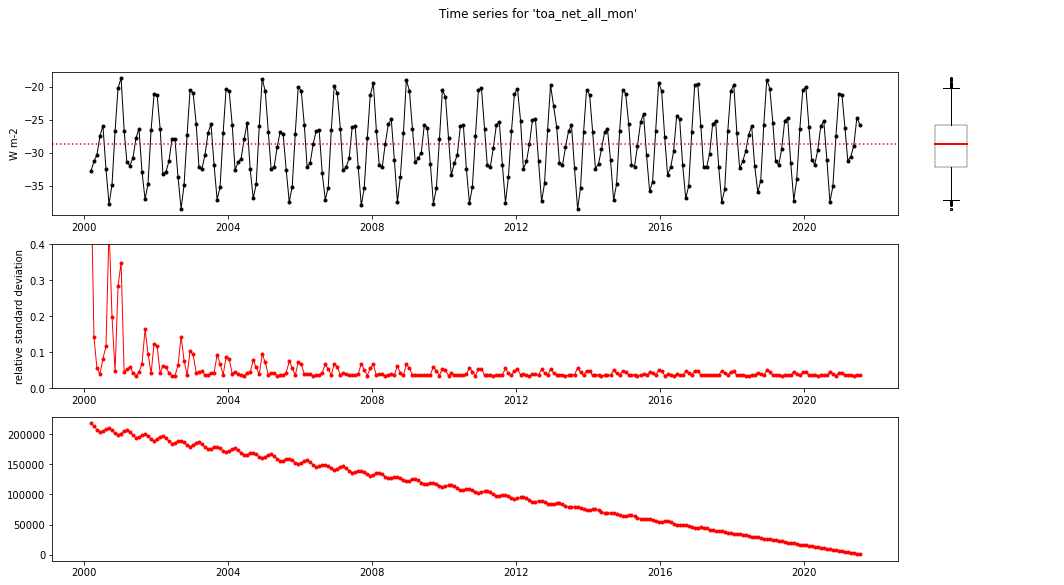

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib import gridspec



def time_series_boxplot(ds,var):
    d = ds[var]
    #x = (ds.time - ds.time[0] ) * 24
    x = d.time
    y = [np.average(timestep) for timestep in d]
    
    mean = np.mean(np.ravel(d))
    std = [(i - mean)**2  for i in y] # standard deviation
    std_cum = []
    for i, e in enumerate(std):
        pre = ([0]+std)[i]
        std_cum.append((e+i)/(i+1))
    
    # create a figure
    fig = plt.figure(figsize=(18,9))
    fig.suptitle('Time series for \'' + var + '\'')
    # create grid for different subplots
    spec = gridspec.GridSpec(ncols=2, nrows=3, width_ratios=[4, 1], wspace=-0.1)
    axs = [fig.add_subplot(spec[0]), fig.add_subplot(spec[1]), fig.add_subplot(spec[2]),fig.add_subplot(spec[4])]
    axs[0].get_shared_y_axes().join(axs[1])
#    axs[0].get_shared_y_axes().join(*axs)

    axs[0].plot(x, y, marker='.', color='black',  linewidth=1)
   
  #  axs[2].plot(x, std + mean, marker='.', color='blue',  linewidth=1)
    axs[2].plot(x, abs(std_cum/mean) , marker='.', color='red',  linewidth=1)
    # if min(std_cum/mean) < 0:
    #     axs[2].set_ylim(min(std_cum/mean)*1.1,0)
    # else:
    #     axs[2].set_ylim(0,max(std_cum/mean)*1.1)
    axs[2].set_ylim(0,0.4)
    
    axs[3].plot(x, autocorr(y) , marker='.', color='red',  linewidth=1)
    
    
    
    
    # axis labels
    # axs[0].set_xlabel('model time [h]')
    if var == 'cre': 
        axs[0].set_ylabel("CRE [$W/m^2$]")
    elif var == 'clt': 
        axs[0].set_ylabel("global mean cloud amount")
    else:
        try: axs[0].set_ylabel(ds[var].units)
        except: pass
    axs[2].set_ylabel("relative standard deviation")
        
    axs[1].boxplot(y, whis=(5, 95), 
                   medianprops=dict(color='red', linewidth=2), 
                   boxprops=dict(linewidth=0.4),
                   flierprops=dict(markersize=2)
                  )

    axs[0].axhline(y=np.median(y), color='red', linestyle=':')
    axs[1].axis('off')
    
    
    return fig


def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]


c = calc_cre(xr.open_dataset(ceres))
# c = c.sel(time=(c.time.dt.month == 12))


vari = 'cre'
# vari = 'solar_mon'
vari = 'toa_net_all_mon'
# vari = 'toa_net_clr_c_mon'
fig = time_series_boxplot(c,vari)
plt.show()

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


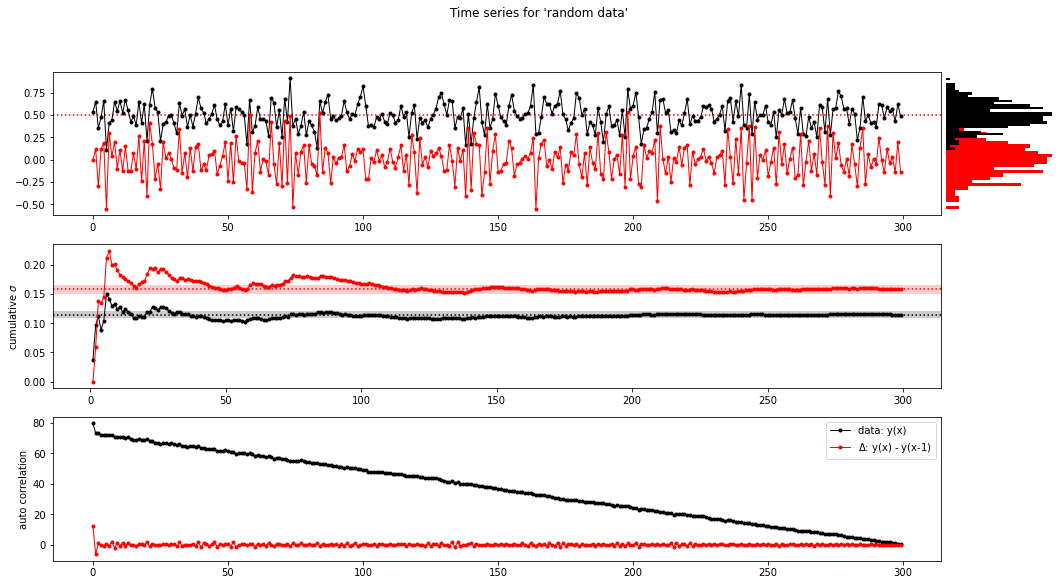

In [121]:
from scipy import signal

def time_series_boxplot(x,y,var, title=False, companion='box'):
    
    if not title: title = var
        
    # create a figure
    fig = plt.figure(figsize=(18,9))
    fig.suptitle('Time series for \'' + title + '\'')
    # create grid for different subplots
    if companion == 'box':
        spec = gridspec.GridSpec(ncols=2, nrows=3, width_ratios=[4, 1], wspace=-0.16)
    elif companion == 'hist':
        spec = gridspec.GridSpec(ncols=2, nrows=3, width_ratios=[4, 0.5], wspace=0.01)
    axs = [fig.add_subplot(spec[0]), fig.add_subplot(spec[1]), fig.add_subplot(spec[2]),fig.add_subplot(spec[4])]
    axs[0].get_shared_y_axes().join(axs[1],axs[0])

    # 1: series and detrended series
    # calc
    y_diff = []
    for i, e in enumerate(y):
        if i == 0: y_diff.append(0)
        else:      y_diff.append(e - y[i-1])
    # plot
    if companion == 'box':
        axs[1].boxplot(y, whis=(5, 95), medianprops=dict(color='red', linewidth=2), 
                       boxprops=dict(linewidth=0.4), flierprops=dict(markersize=2))
    elif companion == 'hist':
        axs[1].hist(y_diff, bins=int(len(y_diff)/10), orientation="horizontal",color='red')
        axs[1].hist(y,      bins=int(len(y)/10),      orientation="horizontal",color='black')
    axs[1].axis('off')
    axs[0].axhline(np.median(y), color='red', linestyle=':')
    axs[0].plot(x, y,      marker='.', linewidth=1, color='black')
    axs[0].plot(x, y_diff, marker='.', linewidth=1, color='red')
   

    # 2: relative standard deviation
    # calc
    std     = [np.sqrt((i - np.mean(y))**2)  for i in y] # standard deviation
    std_cum = [np.average(std[0:i]) for i, e in enumerate(std)] # cumulative standard deviation
    axs[2].plot(x, std_cum , marker='.', color='black',  linewidth=1)
    axs[2].axhline(std_cum[-1], color='black', linestyle=':')
    axs[2].axhspan(std_cum[-1]*0.95, std_cum[-1]*1.05, color='black', alpha=0.2, linewidth=0)
    
    std     = [np.sqrt((i - np.mean(y_diff))**2)  for i in y_diff] # standard deviation
    std_cum = [np.average(std[0:i]) for i, e in enumerate(std)] # cumulative standard deviation
    axs[2].plot(x, std_cum , marker='.', color='red',  linewidth=1)
    axs[2].axhline(std_cum[-1], color='red', linestyle=':')
    axs[2].axhspan(std_cum[-1]*0.95, std_cum[-1]*1.05, color='red', alpha=0.2, linewidth=0)
    axs[2].set_ylabel("cumulative $\sigma$")
 
    # plot 3: autocorrelation
    def autocorr(x):
        # result = np.correlate(x, x, mode='full')
        result = signal.correlate(x, x, mode='full', method='auto')
        return result[int(result.size/2):]
    axs[3].plot(x, autocorr(y),      marker='.', color='black',  linewidth=1, label='data: y(x)')
    axs[3].plot(x, autocorr(y_diff), marker='.', color='red',    linewidth=1, label='$\Delta$: y(x) - y(x-1)')
    axs[3].set_ylabel("auto correlation")
    axs[3].legend()
    
    # axis labels
    # axs[0].set_xlabel('model time [h]')
    if var == 'cre': 
        axs[0].set_ylabel("CRE [$W/m^2$]")
    elif var == 'clt': 
        axs[0].set_ylabel("global mean cloud amount")
    else:
        try: axs[0].set_ylabel(ds[var].units)
        except: pass
        

    
    return fig




x = np.asarray(range(300))
# print(x)
y = [i + 1 for i in x]
y = np.random.rand(len(x)) #* 2 -1
y = np.random.normal(loc=0.5, scale=0.15, size=len(x))
# print(min(y),np.mean(y),max(y))


fig = time_series_boxplot(x,y,'random data', companion='hist')
plt.show()

In [92]:
c.where(c.time.dt.month == 3, drop=True)

<xarray.Dataset>
Dimensions:                      (time: 22, lat: 180, lon: 360)
Coordinates:
  * lon                          (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                         (time) datetime64[ns] 2000-03-15 ... 2021-03-15
Data variables: (12/14)
    toa_sw_all_mon               (time, lat, lon) float32 43.85 43.85 ... 17.9
    toa_lw_all_mon               (time, lat, lon) float32 139.6 139.6 ... 166.8
    toa_net_all_mon              (time, lat, lon) float32 -126.4 ... -164.2
    toa_sw_clr_c_mon             (time, lat, lon) float32 64.47 64.47 ... 40.04
    toa_lw_clr_c_mon             (time, lat, lon) float32 136.6 136.6 ... 167.3
    toa_net_clr_c_mon            (time, lat, lon) float32 -143.9 ... -186.8
    ...                           ...
    cldpress_total_daynight_mon  (time, lat, lon) float32 540.9 540.9 ... 798.5
    cldtemp_total_daynight_mon   (time, lat, lon) float32 228.5 228.5 ... 237.2
    cldtau_total_day_mon         (time, lat, lon) float32 6.038 6.038 ... 2.785
    cre_sw                       (time, lat, lon) float32 20.62 20.62 ... 22.14
    cre_lw                       (time, lat, lon) float32 -3.0 -3.0 ... 0.5 0.5
    cre                          (time, lat, lon) float32 17.62 17.62 ... 22.64
Attributes:
    title:        CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Monthly...
    institution:  NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.1; Release Date May 28, 2019
    DOI:          10.5067/TERRA-AQUA/CERES/EBAF-TOA_L3B004.1

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


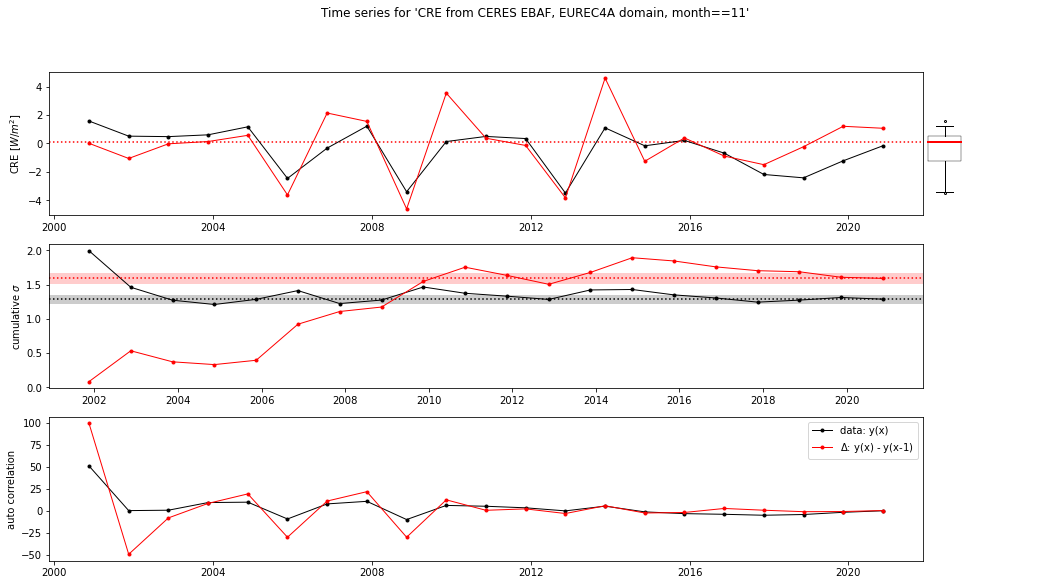

In [131]:
month = 11
a = c.sel(time=(c.time.dt.month == month))
a = a.where((a.lat > 10)    , drop=True).where(a.lat < 20    , drop=True)
a = a.where((a.lon > 360-60), drop=True).where(a.lon < 360-40, drop=True)

var = 'cre'
x = a[var].time
y = [np.average(timestep) for timestep in a[var]]

fig = time_series_boxplot(x,y, var, title='CRE from CERES EBAF, EUREC4A domain, month=='+str(month), companion='box')
plt.show()

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


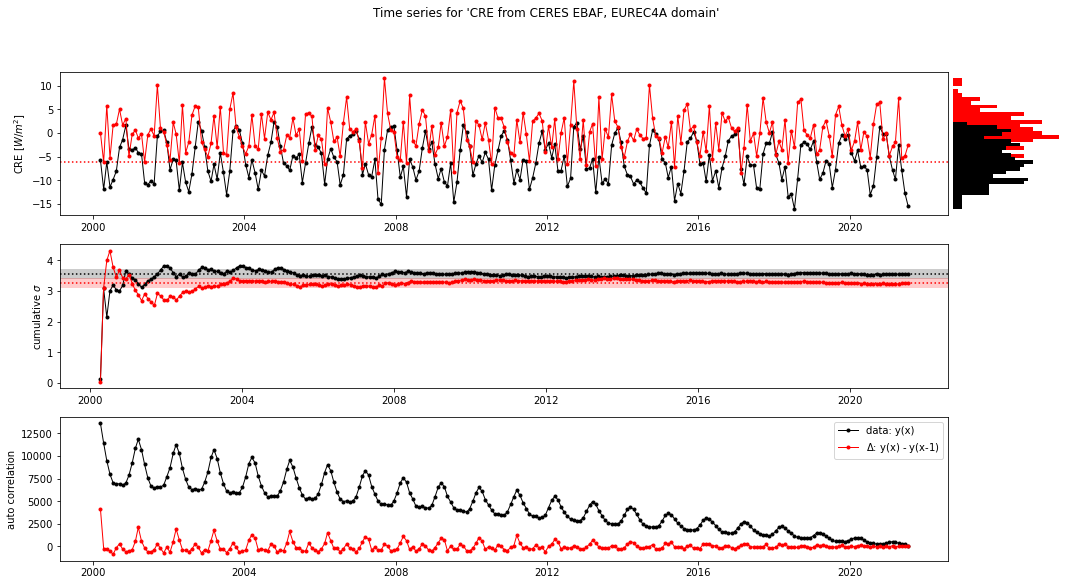

In [122]:
a = c.where((c.lat > 10), drop=True ).where(c.lat < 20, drop=True)
a = a.where((a.lon > 360-60), drop=True).where(a.lon < 360-40, drop=True)

var = 'cre'
x = a[var].time
y = [np.average(timestep) for timestep in a[var]]

fig = time_series_boxplot(x,y, var, title='CRE from CERES EBAF, EUREC4A domain', companion='hist')
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 63


/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


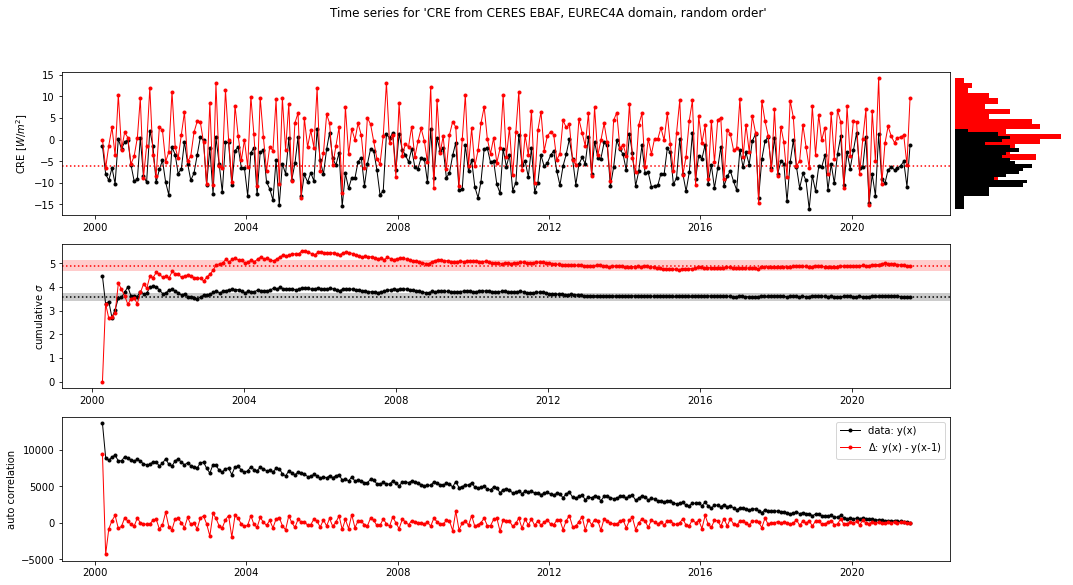

In [146]:
a = c.where((c.lat > 10), drop=True ).where(c.lat < 20, drop=True)
a = a.where((a.lon > 360-60), drop=True).where(a.lon < 360-40, drop=True)

var = 'cre'
x = a[var].time
y = [np.average(timestep) for timestep in a[var]]
np.random.shuffle(y)

fig = time_series_boxplot(x,y, var, 'CRE from CERES EBAF, EUREC4A domain, random order','hist')
plt.show()

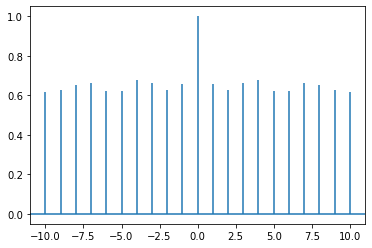

In [159]:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.acorr.html#matplotlib.pyplot.acorr
yy = np.asarray(y)
lags, c, line, b = plt.acorr(yy)

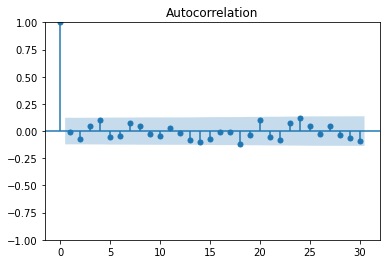

In [168]:
# https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
import statsmodels.api as sm

dta = sm.datasets.sunspots.load_pandas().data
dta = pd.DataFrame(y, columns =['cre'])
sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=30)
plt.show()
